In [3]:
import requests

# URL of the FastAPI endpoint
url = 'http://localhost:5001/health/'

response = requests.get(url)

# Print the response
print(response.json())

ConnectionError: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))

In [19]:
!pip install faster_whisper

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 32.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.4/179.4 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 99.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.3 MB/s eta 0:00:00


# Trying Data Augmentations

In [87]:
!pip install matplotlib librosa audiomentations

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import torch

In [90]:
import wave
import os

def get_sample_rate(file_path):
    with wave.open(file_path, 'rb') as wf:
        sample_rate = wf.getframerate()
    return sample_rate

def get_number_of_channels(file_path):
    with wave.open(file_path, 'rb') as wf:
        num_channels = wf.getnchannels()
    return num_channels

def analyse_data(directory):
    channel_counts = {}
    sample_rate_counts = {}
    for filename in os.listdir(directory):
        if filename.endswith(".wav"):
            file_path = os.path.join(directory, filename)
            num_channels = get_number_of_channels(file_path)
            if num_channels not in channel_counts:
                channel_counts[num_channels] = 1
            else:
                channel_counts[num_channels] += 1
            sample_rate = get_sample_rate(file_path)
            if sample_rate not in sample_rate_counts:
                sample_rate_counts[sample_rate] = 1
            else:
                sample_rate_counts[sample_rate] += 1
    return channel_counts, sample_rate_counts

directory_path = "../../advanced/audio"
channels_info, sample_rate_info = analyse_data(directory_path)
print("Number of channels:")
for channels, count in channels_info.items():
    print(f"{channels} channels: {count} files")
print("Sample rates:")
for sample_rate, count in sample_rate_info.items():
    print(f"{sample_rate} Hz: {count} files")

Number of channels:
1 channels: 3500 files
Sample rates:
16000 Hz: 3500 files


### Data Analysis
Number of channels:
- 1 channels: 3500 files

Sample rates:
- 16000 Hz: 3500 files

In [5]:
SAMPLE_RATE = 16000
N_MFCC = 13

In [6]:
def view_waveform(audio_data, sample_rate=SAMPLE_RATE):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio_data, sr=sample_rate)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

In [7]:
def view_spectrogram(audio_data, sample_rate=SAMPLE_RATE):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

In [8]:
def convert_to_mel_spectrogram(audio_data, sample_rate=SAMPLE_RATE):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=80)
    return mel_spectrogram

def view_mel_spectrogram(audio_data=None, sample_rate=SAMPLE_RATE, mel_spectrogram=None):
    if mel_spectrogram is None:
        # Compute the Mel spectrogram
        mel_spectrogram = convert_to_mel_spectrogram(audio_data)
    
    # Convert to decibel scale
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Plot the Mel spectrogram
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.show()

In [9]:
def view_mfccs(audio_data, sample_rate=SAMPLE_RATE):
    # Compute MFCCs
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=N_MFCC)

    # Display MFCCs
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mfccs, x_axis='time', sr=sample_rate)
    plt.colorbar()
    plt.title('MFCCs')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.show()

22050


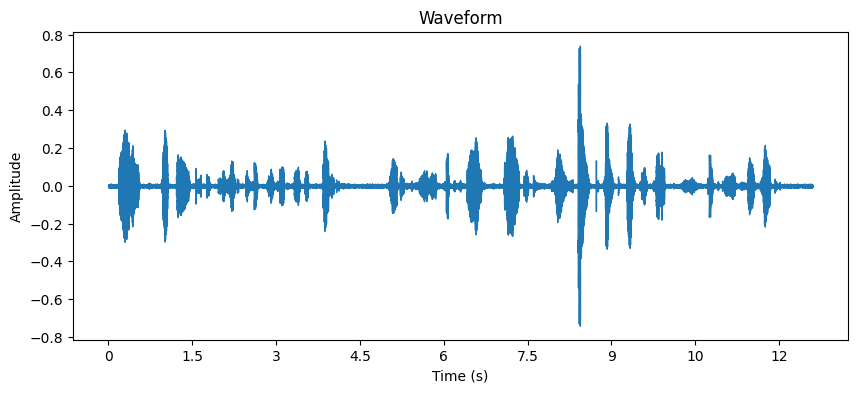

/var/tmp/ipykernel_25467/1612334693.py:3: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  librosa.display.specshow(librosa.amplitude_to_db(librosa.stft(audio_data), ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')


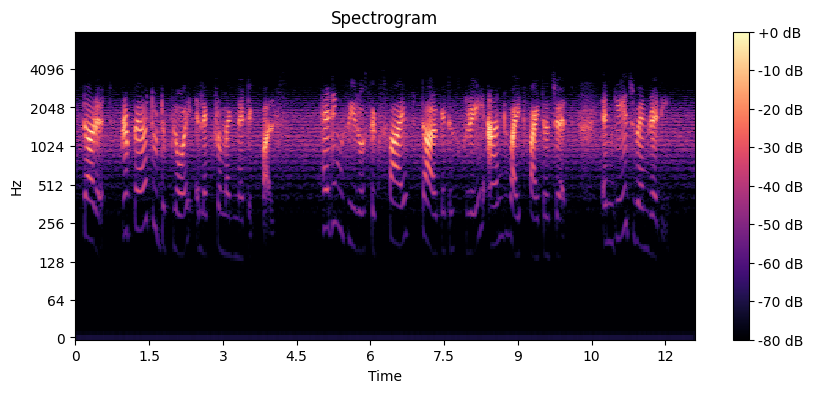

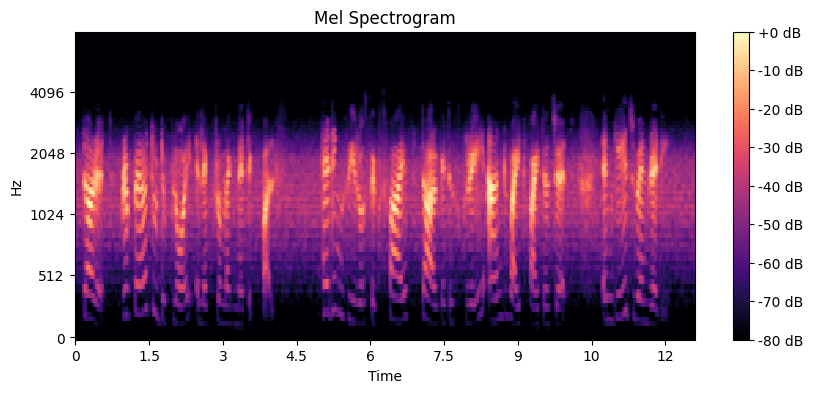

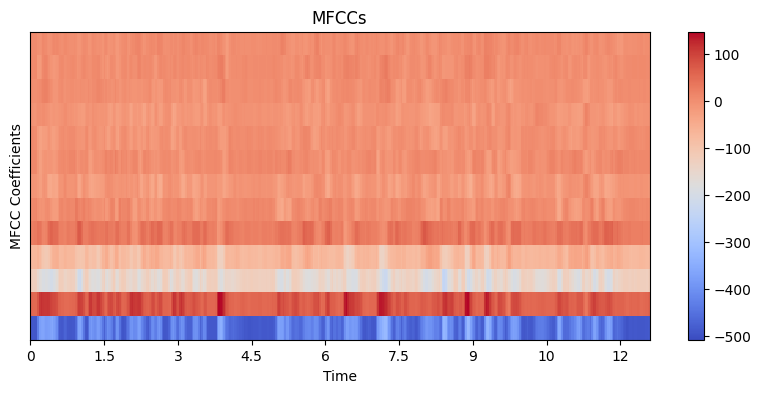

In [10]:
# Visualise sample audio from training data

audio_data, sample_rate = librosa.load("../../advanced/audio/audio_0.wav")

print(sample_rate)
view_waveform(audio_data)
view_spectrogram(audio_data)
view_mel_spectrogram(audio_data)
view_mfccs(audio_data)

torch.Size([146286])


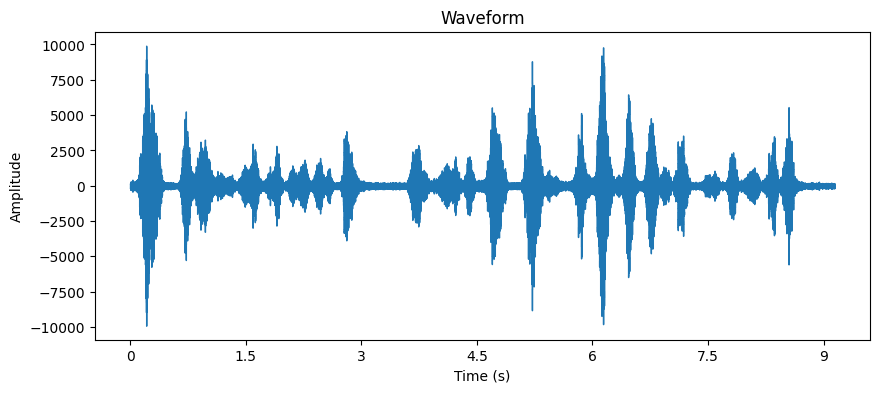

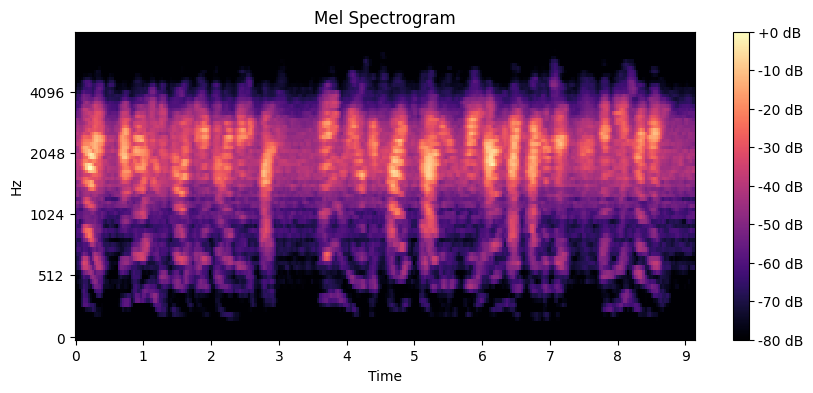

In [11]:
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift

augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

sample_rate, audio_data = wavfile.read("../../advanced/audio/audio_0.wav")

# Convert audio data to floating-point format and numpy array
audio_data = audio_data.astype(np.float32)

# Augment/transform/perturb the audio data
augmented_samples = augment(samples=audio_data, sample_rate=SAMPLE_RATE)

print(torch.from_numpy(augmented_samples).shape)
view_waveform(augmented_samples)
view_mel_spectrogram(augmented_samples)

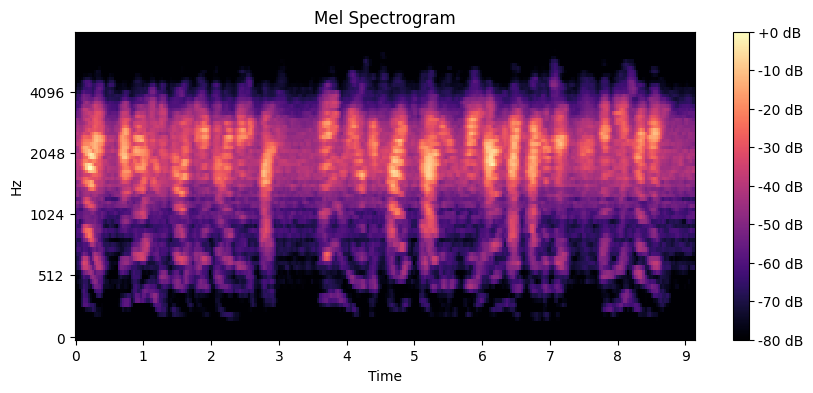

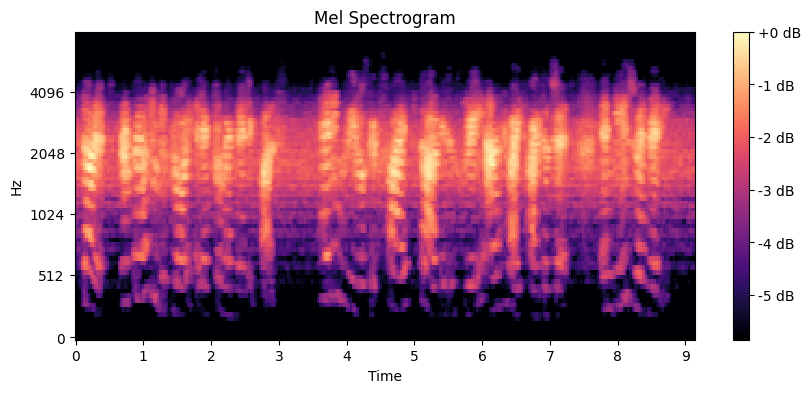

torch.Size([80, 286])


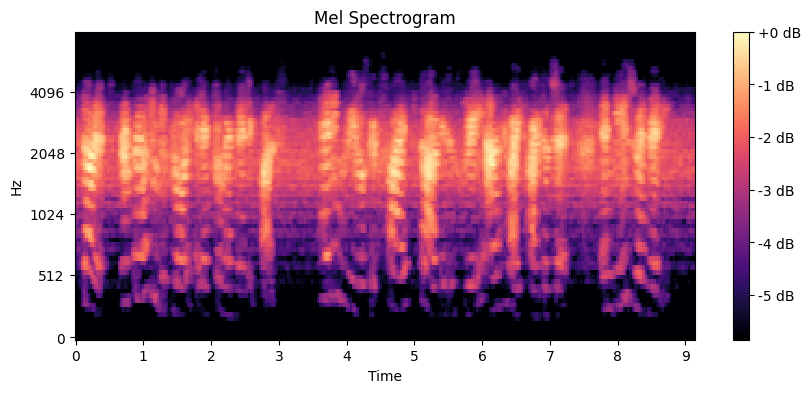

In [18]:
# time and frequency masking for mel spectrogram
from audiomentations import SpecCompose, SpecChannelShuffle, SpecFrequencyMask

augment = SpecCompose(
    [
        SpecFrequencyMask(p=0.5),
    ]
)

spectrogram = convert_to_mel_spectrogram(augmented_samples)
view_mel_spectrogram(mel_spectrogram=spectrogram)

spectrogram = librosa.power_to_db(spectrogram)
view_mel_spectrogram(mel_spectrogram=spectrogram)

print(torch.from_numpy(spectrogram).shape)

# Augment/transform/perturb the spectrogram
augmented_spectrogram = augment(spectrogram)

view_mel_spectrogram(mel_spectrogram=augmented_spectrogram)

# Finetuning Whisper

In [4]:
!pip install --upgrade pip
!pip install --upgrade datasets[audio] transformers accelerate evaluate jiwer tensorboard gradio

In [12]:
from huggingface_hub import notebook_login

notebook_login()

In [7]:
# Calculate the number of samples needed for padding
DESIRED_DURATION_SECONDS = 30
SAMPLE_RATE = 16000
TARGET_NUM_SAMPLES = int(DESIRED_DURATION_SECONDS * SAMPLE_RATE)
print(TARGET_NUM_SAMPLES)

480000


### asr.jsonl

{"key": 0, "audio": "audio_0.wav", "transcript": "Turret, prepare to deploy electromagnetic pulse. Heading zero six five, target is grey and white fighter jet. Engage when ready."}

In [252]:
# Get Audio Info DataFrame from asr.jsonl

import pandas as pd
import json
import base64

input_dir = "../../advanced"
instances = []

with open(f"{input_dir}/asr.jsonl", "r") as f:
    for line in f:
        if line.strip() == "":
            continue
        instance = json.loads(line.strip())
        with open(f"{input_dir}/audio/{instance['audio']}", "rb") as file:
            audio_bytes = file.read()
            instances.append(
                {**instance, "b64": base64.b64encode(audio_bytes).decode("ascii")}
            )
            
df = pd.DataFrame(instances)
print(df.head())
print(df.iloc[0]['transcript'])

   key        audio                                         transcript  \
0    0  audio_0.wav  Turret, prepare to deploy electromagnetic puls...   
1    1  audio_1.wav  Engage yellow drone with surface-to-air missil...   
2    2  audio_2.wav  Control to turrets, deploy electromagnetic pul...   
3    3  audio_3.wav  Alfa, Echo, Mike Papa, deploy EMP tool heading...   
4    4  audio_4.wav  Engage the grey, black, and green fighter plan...   

                                                 b64  
0  UklGRgB3BABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...  
1  UklGRubrAgBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...  
2  UklGRgCXBwBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...  
3  UklGRiRgBABXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...  
4  UklGRvaYAwBXQVZFZm10IBAAAAABAAEAgD4AAAB9AAACAB...  
Turret, prepare to deploy electromagnetic pulse. Heading zero six five, target is grey and white fighter jet. Engage when ready.


In [326]:
from torch.utils.data import Dataset
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, SpecCompose, SpecFrequencyMask

class AudioAugDataset(Dataset):
    def __init__(self, df, data_path, wav_augment=None, spec_augment=None, tokenizer=None):
        self.df = df
        self.tokenizer = tokenizer
        self.data_path = str(data_path)
        self.wav_augment = wav_augment
        self.spec_augment = spec_augment
        self.sample_rate = 16000
        self.channel = 1
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Load audio file
        sample_rate, audio_data = wavfile.read(f"{data_path}/audio/{self.df.iloc[idx]['audio']}")
        
        # Convert audio data to floating-point format and numpy array
        audio_data = audio_data.astype(np.float32)
        
        # Pad the audio signal if it's shorter than the target duration
        # 480000 = TARGET_NUM_SAMPLES
        if len(audio_data) < 480000:
            padding_needed = 480000 - len(audio_data)
            audio_data = np.pad(audio_data, (0, padding_needed), mode='constant')
        
        if self.wav_augment:
            # Augment/transform/perturb the audio data
            audio_data = self.wav_augment(samples=audio_data, sample_rate=self.sample_rate)
        
        spectrogram = convert_to_mel_spectrogram(audio_data)

        if self.spec_augment:
            # Augment/transform/perturb the spectrogram
            spectrogram = self.spec_augment(spectrogram)
        
        # Convert to PyTorch tensor
        # audio_tensor = torch.from_numpy(audio_data)
        spectrogram_tensor = torch.from_numpy(spectrogram)
        
        # Pad spectrogram tensor to 3000
        target_length = 3000
        if spectrogram_tensor.size(1) < target_length:
            padding = (0, target_length - spectrogram_tensor.size(1))
            spectrogram_tensor = torch.nn.functional.pad(spectrogram_tensor, padding)
        
        # Get label from DataFrame
        label = self.df.iloc[idx]['transcript']
        
        input_ids = self.tokenizer(label).input_ids
        
        return {'input_features': spectrogram_tensor, 'label': input_ids}

In [327]:
wav_augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    Shift(min_shift=-0.5, max_shift=0.5, p=0.5),
])

spec_augment = SpecCompose(
    [
        SpecFrequencyMask(p=0.5),
    ]
)

data_path = "../../advanced"

audioAugDataset = AudioAugDataset(df, data_path, wav_augment, spec_augment, tokenizer)

In [328]:
from transformers import WhisperFeatureExtractor, WhisperTokenizer

feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="English", task="transcribe")

from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
model.generation_config.language = "english"
model.generation_config.task = "transcribe"
model.generation_config.forced_decoder_ids = None

from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="English", task="transcribe")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [329]:
from torch.utils.data import DataLoader, random_split

# Random split of 80:20 between training and validation
num_items = len(audioAugDataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(audioAugDataset, [num_train, num_val])

# Create training data loader
# train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
# val_dl = DataLoader(val_ds, batch_size=16, shuffle=True)

In [330]:
train_ds[0]

{'input_features': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'label': [50258,
  50259,
  50359,
  50363,
  29821,
  6623,
  10567,
  281,
  1988,
  7654,
  3243,
  9675,
  11,
  7274,
  3479,
  3874,
  11,
  9864,
  1045,
  1732,
  4018,
  11,
  4683,
  6292,
  1442,
  9465,
  13,
  50257]}

In [331]:
train_ds[1]['input_features'].shape

torch.Size([80, 3000])

In [332]:
tokenizer("God help me")

{'input_ids': [50258, 50259, 50359, 50363, 18358, 854, 385, 50257], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}

In [333]:
import evaluate

metric = evaluate.load("wer")

In [334]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [335]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List) -> Dict[str, torch.Tensor]:
        
        # print(features)
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["label"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch
    
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)

In [336]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-hi",  # change to a repo name of your choice
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  # increase by 2x for every 2x decrease in batch size
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=5000,
    gradient_checkpointing=True,
    # fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
)

from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    tokenizer=tokenizer
)

max_steps is given, it will override any value given in num_train_epochs


In [1]:
trainer.train()

NameError: name 'trainer' is not defined

In [ ]:
kwargs = {
    "dataset_tags": "DSTA BrainHack TILAI",
    "dataset": "DSTA BrainHack TILAI",  # a 'pretty' name for the training dataset
    "dataset_args": "config: en, split: test",
    "language": "en",
    "model_name": "Whisper BrainHack TILAI",  # a 'pretty' name for your model
    "finetuned_from": "openai/whisper-small",
    "tasks": "automatic-speech-recognition",
}